### Basic model:
Features: Income, Household composition, Property type
Predict installed pV per household (aggregation level: buurt, no time dependency) 

Income: CBS data '84799NED' (Kerncijfers wijken en buurten 2020)

In [49]:
# pip install cbsodata

In [50]:
import cbsodata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path

In [51]:
#Read in (Kerncijfers wijken en buurten 2020
kerncijfers_2020 = '84799NED'
path_kerncijfers_2020 = Path('../Data/CBS/84799NED.csv')
if(os.path.exists(path_kerncijfers_2020) == False):
    print("File does not exist. Downloading from CBS....")
    df_temp = pd.DataFrame(cbsodata.get_data(kerncijfers_2020))
    print("File downloaded.")
    df_temp.to_csv(path_or_buf=path_kerncijfers_2020)
    print("File stored on local file stystem.")
    
df_kerncijfers = pd.read_csv(path_kerncijfers_2020)
df_kerncijfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17341 entries, 0 to 17340
Columns: 119 entries, Unnamed: 0 to Omgevingsadressendichtheid_116
dtypes: float64(74), int64(39), object(6)
memory usage: 15.7+ MB


Remove unusable items

In [52]:
df_kerncijfers = df_kerncijfers[df_kerncijfers['Codering_3'].isna() == False]

Keep only the data on Buurt level

In [53]:
#remove whitespaces from beginning and end of string column labels
df_kerncijfers = df_kerncijfers.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

is_buurt = df_kerncijfers['SoortRegio_2']=='Buurt'
df_kerncijfers = df_kerncijfers[is_buurt]

df_kerncijfers.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13808 entries, 3 to 17340
Columns: 119 entries, Unnamed: 0 to Omgevingsadressendichtheid_116
dtypes: float64(74), int64(39), object(6)
memory usage: 12.6+ MB


Filter out the non residential areas

In [54]:
df_kerncijfers['WijkenEnBuurten_lower_case'] = df_kerncijfers['WijkenEnBuurten'].str.lower()
df_kerncijfers['Is_non_residential'] = (df_kerncijfers['WijkenEnBuurten_lower_case'].str.contains('bedrijventerrein') |
    df_kerncijfers['WijkenEnBuurten_lower_case'].str.contains('bedrijvengebied') |
    df_kerncijfers['WijkenEnBuurten_lower_case'].str.contains('landelijk') |
    df_kerncijfers['WijkenEnBuurten_lower_case'].str.contains('kantoren') |
    df_kerncijfers['WijkenEnBuurten_lower_case'].str.contains('industrieterrein') |
    df_kerncijfers['WijkenEnBuurten_lower_case'].str.contains('industriegebied'))

df_kerncijfers = df_kerncijfers[df_kerncijfers['Is_non_residential'] == False]
df_kerncijfers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13406 entries, 3 to 17340
Columns: 121 entries, Unnamed: 0 to Is_non_residential
dtypes: bool(1), float64(74), int64(39), object(7)
memory usage: 12.4+ MB


### Feature #1 - Income

Take a look at the number of buurten where the incomes are unknown

In [55]:
# dab = df_kerncijfers[df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna()]
# dab.info()

# dab[['WijkenEnBuurten', 'GemiddeldInkomenPerInwoner_72' ]].head()
df_kerncijfers[df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna()].sum()

Unnamed: 0                                                                 98674641
ID                                                                         98674641
WijkenEnBuurten                   Verspreide huizen AnnenEextVerspreide huizen E...
Gemeentenaam_1                    Aa en HunzeAa en HunzeAa en HunzeAa en HunzeAa...
SoortRegio_2                      BuurtBuurtBuurtBuurtBuurtBuurtBuurtBuurtBuurtB...
                                                        ...                        
Dekkingspercentage_114                                                      14121.0
MateVanStedelijkheid_115                                                    42875.0
Omgevingsadressendichtheid_116                                           11744485.0
WijkenEnBuurten_lower_case        verspreide huizen anneneextverspreide huizen e...
Is_non_residential                                                                0
Length: 121, dtype: object

In [56]:
total_no_income = df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna().sum()
fraction_unfilled_incomes = total_no_income / len(df_kerncijfers.index)  * 100

print("Income not specified in: %.0f" % fraction_unfilled_incomes, "% of the buurten.")

Income not specified in: 85 % of the buurten.


## 85% of the data incomes are not filled.

Approach #1: impute the missing values with the mean, so we have enough items to train our model

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13406 entries, 3 to 17340
Columns: 121 entries, Unnamed: 0 to Is_non_residential
dtypes: bool(1), float64(74), int64(39), object(7)
memory usage: 12.4+ MB


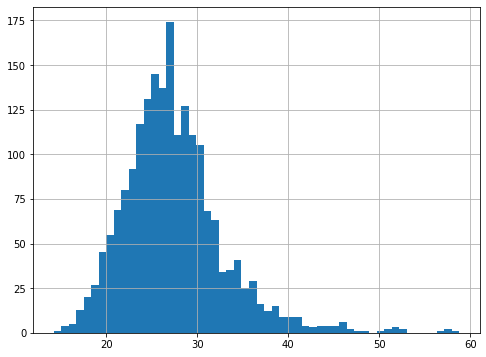

In [57]:
cutoff_income = 60

df_income_specified = df_kerncijfers[df_kerncijfers['GemiddeldInkomenPerInwoner_72'] < cutoff_income]
df_income_specified['GemiddeldInkomenPerInwoner_72'].hist(bins=54, figsize=(8, 6))

df_kerncijfers.info()

In [58]:
#impute the incomes
mean_income = df_kerncijfers['GemiddeldInkomenPerInwoner_72'].mean()
df_kerncijfers['GemiddeldInkomenPerInwoner_72'].fillna(mean_income)

3        28.800000
4        27.428933
6        27.428933
7        27.428933
9        27.428933
           ...    
17335    26.900000
17336    26.300000
17337    27.428933
17339    27.428933
17340    27.428933
Name: GemiddeldInkomenPerInwoner_72, Length: 13406, dtype: float64

### Feature #2 - Household composition

In [59]:
fraction_unfilled_huishoudensgroottes = df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].isna().sum()/ df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].sum() *100

print("Average size of household not specified in: %.0f" % fraction_unfilled_huishoudensgroottes, "% of the buurten. Removing these entries.")

Average size of household not specified in: 1 % of the buurten. Removing these entries.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13099 entries, 3 to 17340
Columns: 121 entries, Unnamed: 0 to Is_non_residential
dtypes: bool(1), float64(74), int64(39), object(7)
memory usage: 12.1+ MB


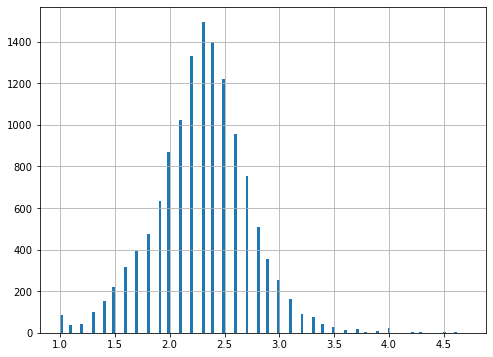

In [60]:
cut_off_household_size = 5
df_kerncijfers = df_kerncijfers[df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].isna() == False]

df_average_household_size_specified = df_kerncijfers[df_kerncijfers['GemiddeldeHuishoudensgrootte_32']<cut_off_household_size]
df_average_household_size_specified['GemiddeldeHuishoudensgrootte_32'].hist(bins=140, figsize=(8, 6))

df_kerncijfers.info()

### Feature #3 - Percentage owned property (koopwoningen)

In [61]:
fraction_unfilled_owned_property_percentage = df_kerncijfers['Koopwoningen_40'].isna().sum()/ df_kerncijfers['Koopwoningen_40'].sum() *100

print("Average percentage of owned properties not specified in: %.0f" % fraction_unfilled_owned_property_percentage, "% of the buurten.")


Average percentage of owned properties not specified in: 0 % of the buurten.


Remove the 'BU' from the buurtcode and rename the column name so we can combine the datasets later

In [62]:
has_buurtcode_starting_with_BU = df_kerncijfers['Codering_3'].str.find('BU') == 0
buurtcodes_without_leading_BU = df_kerncijfers[has_buurtcode_starting_with_BU == False]
print("Number of buurten that don't start with 'BU': ", len(buurtcodes_without_leading_BU))

df_kerncijfers['CBS Buurtcode'] = pd.to_numeric(df_kerncijfers['Codering_3'].apply(lambda s:s.replace("BU","")))

df_kerncijfers.info()

Number of buurten that don't start with 'BU':  0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13099 entries, 3 to 17340
Columns: 122 entries, Unnamed: 0 to CBS Buurtcode
dtypes: bool(1), float64(74), int64(40), object(7)
memory usage: 12.2+ MB


In [63]:
print("Duplicate buurtcodes: %.0f" % df_kerncijfers.duplicated(['CBS Buurtcode']).sum())
df_kerncijfers.astype({"CBS Buurtcode" : int})
df_kerncijfers.head()

Duplicate buurtcodes: 0


,Unnamed: 0,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,...,OppervlakteTotaal_110,OppervlakteLand_111,OppervlakteWater_112,MeestVoorkomendePostcode_113,Dekkingspercentage_114,MateVanStedelijkheid_115,Omgevingsadressendichtheid_116,WijkenEnBuurten_lower_case,Is_non_residential,CBS Buurtcode
3,3,3,Annen,Aa en Hunze,Buurt,BU16800000,1,3460,1685,1775,...,252,252,0,9468,1.0,5.0,411.0,annen,False,16800000
4,4,4,Verspreide huizen Annen,Aa en Hunze,Buurt,BU16800009,1,155,80,80,...,1226,1213,13,9468,1.0,5.0,60.0,verspreide huizen annen,False,16800009
6,6,6,Eext,Aa en Hunze,Buurt,BU16800100,1,1255,640,615,...,171,170,1,9463,1.0,5.0,144.0,eext,False,16800100
7,7,7,Verspreide huizen Eext,Aa en Hunze,Buurt,BU16800109,1,175,90,85,...,1618,1611,6,9463,1.0,5.0,36.0,verspreide huizen eext,False,16800109
9,9,9,Anloo,Aa en Hunze,Buurt,BU16800200,1,320,150,170,...,57,57,0,9467,1.0,5.0,126.0,anloo,False,16800200


Take a look at the # of households per buurt. We need this to be able to 'normalize' the installed pV

In [64]:
print("Huishoudens totaal has: ", (df_kerncijfers['HuishoudensTotaal_28'].isna() == True).sum(), " empty items.")

Huishoudens totaal has:  0  empty items.


## Target variable - opgesteld vermogen

Load the data from the Enexis supplied data file.

In [65]:
decentral_generation_072020 = '../Data/Enexis_decentrale_opwek_kv_(zon_pv)_01072020.csv'
df_decentral_generation = pd.read_csv(decentral_generation_072020,
                         sep                = ';',
                         decimal            = ',',
                         thousands          = '.',
                         encoding           = 'unicode_escape')
df_decentral_generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4081 entries, 0 to 4080
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ï»¿Peildatum                               4077 non-null   float64
 1   Netbeheerder                               4077 non-null   object 
 2   Provincie                                  4076 non-null   object 
 3   Gemeente                                   4074 non-null   object 
 4   CBS Buurt                                  3946 non-null   object 
 5   CBS Buurtcode                              3946 non-null   float64
 6   Aantal aansluitingen in CBS-buurt          4076 non-null   float64
 7   Aantal aansluitingen met opwekinstallatie  4077 non-null   float64
 8   Opgesteld vermogen                         4077 non-null   float64
dtypes: float64(5), object(4)
memory usage: 287.1+ KB


Remove empty items

In [66]:
df_decentral_generation = df_decentral_generation[df_decentral_generation['Opgesteld vermogen'].isna() == False]
df_decentral_generation = df_decentral_generation[df_decentral_generation['CBS Buurtcode'].isna() == False]

## Note: the unit of 'opgesteld vermogen' is kW

<AxesSubplot:>

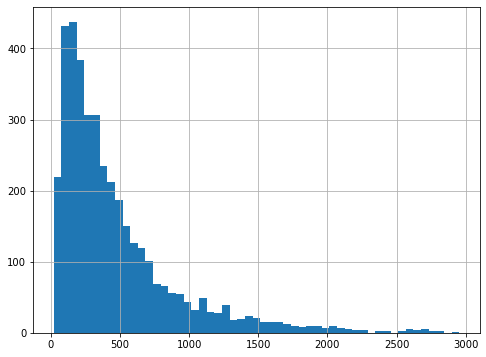

In [67]:
cut_off_generation = 3000

df_decentral_generation_specified = df_decentral_generation[df_decentral_generation['Opgesteld vermogen'] < cut_off_generation]
df_decentral_generation_specified['Opgesteld vermogen'].hist(bins=53, figsize=(8, 6))

In [68]:
print("Duplicate buurtcodes: %.0f" % df_decentral_generation.duplicated(['CBS Buurtcode']).sum())
df_decentral_generation.astype({"CBS Buurtcode" : int})

Duplicate buurtcodes: 0


,ï»¿Peildatum,Netbeheerder,Provincie,Gemeente,CBS Buurt,CBS Buurtcode,Aantal aansluitingen in CBS-buurt,Aantal aansluitingen met opwekinstallatie,Opgesteld vermogen
0,202007.0,Enexis,Drenthe,Aa en Hunze,Annen,16800000,1491.0,447.0,1866.0
1,202007.0,Enexis,Drenthe,Aa en Hunze,Verspreide huizen Annen,16800009,116.0,29.0,243.0
2,202007.0,Enexis,Drenthe,Aa en Hunze,Eext,16800100,559.0,143.0,565.0
3,202007.0,Enexis,Drenthe,Aa en Hunze,Verspreide huizen Eext,16800109,127.0,24.0,150.0
4,202007.0,Enexis,Drenthe,Aa en Hunze,Anloo,16800200,127.0,29.0,129.0
...,...,...,...,...,...,...,...,...,...
4070,202007.0,Enexis,Overijssel,Zwolle,Gerenlanden,1935140,1218.0,323.0,992.0
4071,202007.0,Enexis,Overijssel,Zwolle,Gerenbroek,1935150,1217.0,315.0,949.0
4072,202007.0,Enexis,Overijssel,Zwolle,Oude Mars,1935160,59.0,19.0,127.0
4073,202007.0,Enexis,Overijssel,Zwolle,Windesheim,1935200,143.0,34.0,165.0


Check if the deduplication was successfull

### Combine the demographic data with the generation data

In [69]:
print("Number of rows in 'kerncijfers': %.0f" % len(df_kerncijfers))
print("Number of rows in 'generation data': %.0f" % len(df_decentral_generation))

df = pd.merge(df_kerncijfers, df_decentral_generation, on="CBS Buurtcode", validate='one_to_one')
print("Number of rows in combined data set: %.0f" % len(df))


Number of rows in 'kerncijfers': 13099
Number of rows in 'generation data': 3946
Number of rows in combined data set: 3117


#### To do: check why not more rows match on buurt code

### Introduce a normalized column. normalized_opgesteld_vermogen = opgesteld_vermogen / #households

In [70]:
df["normalized_opgesteld_vermogen"] = (df["Opgesteld vermogen"] / df["HuishoudensTotaal_28"])

## Create a first model - linear model

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import altair as alt

In [72]:
opgesteld_vermogen = 'normalized_opgesteld_vermogen'
columns_to_keep = [opgesteld_vermogen, 'GemiddeldInkomenPerInwoner_72', 'GemiddeldeHuishoudensgrootte_32', 'Koopwoningen_40']
# columns_to_keep = [opgesteld_vermogen, 'GemiddeldeHuishoudensgrootte_32', 'Koopwoningen_40']
df = df[columns_to_keep]

train_set, test_set = train_test_split(df, test_size=0.2)

print(f"training set size: {len(train_set)}\ntest set size: {len(test_set)}")

Y_train_set = train_set[opgesteld_vermogen]
X_train_set = train_set.drop(opgesteld_vermogen, axis=1).copy()

Y_test_set = test_set[opgesteld_vermogen]
X_test_set = test_set.drop(opgesteld_vermogen, axis=1).copy()

lin_reg = LinearRegression()
lin_reg.fit(X_train_set, Y_train_set)

training set size: 2493
test set size: 624


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Plot the fit with income

In [ ]:
alt.renderers.enable('default')

base = alt.Chart(train_set).mark_circle().encode(
    alt.X('GemiddeldInkomenPerInwoner_72',
     title='# income'),
       alt.Y(opgesteld_vermogen,
     title='Opgesteld vermogen')
)

linear_fit = [
    base.transform_regression(
        "GemiddeldInkomenPerInwoner_72", opgesteld_vermogen, method="linear"
    )
    .mark_line()   
]

graph = alt.layer(base, *linear_fit)
graph

alt.LayerChart(...)

#### Check the quality of the model

In [ ]:
# Make predictions using the testing set
y_pred = lin_reg.predict(X_test_set)

# The coefficients
print("Coefficients: \n", lin_reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test_set, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test_set, y_pred))

Coefficients: 
 [-0.00831757  0.18883239  0.01199666]
Mean squared error: 0.06
Coefficient of determination: 0.43


## Create a first model - tree model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Create helper class

In [ ]:
class Result:
  def __init__(self, r_squared, mean_squared_error):
    self.r_squared = r_squared
    self.mean_squared_error = mean_squared_error

In [ ]:
results = {}

max_range = 10

# Fit regression models
for i in range(1, max_range):
    r = DecisionTreeRegressor(max_depth=i, random_state=3)
    r.fit(X_train_set, Y_train_set)
    y_predict = r.predict(X_test_set)
    results[i] = Result(r2_score(Y_test_set, y_predict), mean_squared_error(Y_test_set, y_predict)) 

#### Check the quality of the models

# Mark down

In [ ]:
for i in range(1,max_range):
    print("Depth  %2.f" % i, ":R squared: %.2f" % results[i].r_squared,
    "-- Mean squared error: %.0f" % results[i].mean_squared_error)


Depth   1 :R squared: 0.36 -- Mean squared error: 0
Depth   2 :R squared: 0.44 -- Mean squared error: 0
Depth   3 :R squared: 0.47 -- Mean squared error: 0
Depth   4 :R squared: 0.45 -- Mean squared error: 0
Depth   5 :R squared: 0.42 -- Mean squared error: 0
Depth   6 :R squared: 0.30 -- Mean squared error: 0
Depth   7 :R squared: 0.25 -- Mean squared error: 0
Depth   8 :R squared: 0.31 -- Mean squared error: 0
Depth   9 :R squared: 0.29 -- Mean squared error: 0


Best performance is at depth = 2 (Not the same over runs &#9785; though)

In [ ]:
optimum_depth = 2
print("Depth  %2.f" % optimum_depth, ":R squared: %.2f" % results[optimum_depth].r_squared,
    "-- Mean squared error: %.0f" % results[optimum_depth].mean_squared_error)

Depth   2 :R squared: 0.44 -- Mean squared error: 0
